<a href="https://colab.research.google.com/github/felladib/H_SentimentAnalysis_REC/blob/main/H_SCARS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***import lib***

In [ ]:
import tensorflow as tf
import math
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import re
import os
from tqdm import tqdm



import keras
from keras.layers import Embedding
from keras.layers.core import Flatten
from keras.layers import Multiply, Dense, Input
from keras.models import Model
from keras.layers import concatenate
from keras.models import load_model
from keras.callbacks import EarlyStopping


import math
from time import time
import pickle

import nltk
from nltk.corpus import stopwords
from string import punctuation

from tensorflow.keras.datasets import imdb
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## ***la matrice de confiance***

In [ ]:
# relu fonction permet de retourner x or 0 dans le cas ou x<0
def relu(x):
    return (np.maximum(0,x))
#  build_confidence_M fonction permet de retourner un vecteur qui contient la valeur de confiance pour chaque row (user , item ) dans notre dataset
def build_confidence_M(dataset_item, dataset_user, emb_dataset,i ):
  confidence_M = np.zeros(dataset_user.shape[0]) # intialiser la matrice par des zeros
  #i = 0
  for index, row in emb_dataset.iterrows():
    user   = row['user_id']
    item   = row['item_id']
    rating = row['rating']
    # recupere l user qu'on veut lui calcule la valeur de confinace par rapport un item
    if rating<= 3:
      nb1 = 0
      nb2 = 0
      sum1 = 0
      sum2 = 0
      #  recperer tt les ratings de cet user par rapport au autre items
      for x in dataset_user['user_id']:

        if (user == dataset['user_id'][x]):
          if (item != dataset['item_id'][x] and dataset['rating'][x] <= 3):
            nb1 = nb1+1
            sum1 = sum1 + dataset['rating'][x]
      #  la moyenne de ratings
      if(nb1!=0):
        result1 = sum1/nb1 #la somme des ratings divisé par le nombre de ratings (<=3)
        result1 = result1 - rating #rating : la note qu'a donné l'utilisateur considéré [i] à l'item considéré [i]
        result1 = abs(result1)
        result1 = result1 - 0.8  #0.8 :
        result1 = - relu(result1) # ReLU : permet de remplacer les resultats négatifs par 0
      else: result1 = 0
      #  recuperer tt les ratings donner  par les autre users a cet item
      for y in dataset_item['item_id']:

        if (item == dataset['item_id'][y]):
          if (user != dataset['user_id'][y] and dataset['rating'][y] <= 3):
            nb2 = nb2+1
            sum2 = sum2 + dataset['rating'][y]

    #   calcule la moyenne de ratings
      if(nb2!=0):
        result2 = sum2/nb2
        result2 = result2 - rating
        result2 = abs(result2)
        result2 = result2 - 0.8
        result2 = - relu(result2)
      else: result2 = 0
      result = result1 + result2
      result = math.exp(result)
      # return result
    # les meme etap si rating >3
    elif rating > 3:
      nb1 = 0
      nb2 = 0
      sum1 = 0
      sum2 = 0
      for x in dataset_user['user_id']:
        if (user == dataset['user_id'][x]):
          if (item != dataset['item_id'][x] and dataset['rating'][x] > 3):
            nb1 = nb1+1
            sum1 = sum1 + dataset['rating'][x]
      if(nb1!=0):
        result1 = sum1/nb1
        result1 = result1 - rating
        result1 = abs(result1)
        result1 = result1 - 0.8
        result1 = - relu(result1)
      else: result1 = 0
      for y in dataset_item['item_id']:
        if (item == dataset['item_id'][y]):
          if (user != dataset['user_id'][y] and dataset['rating'][y] > 3):
            nb2 = nb2+1
            sum2 = sum2 + dataset['rating'][y]
      if(nb2!=0):
        result2 = sum2/nb2
        result2 = result2 - rating
        result2 = abs(result2)
        result2 = result2 - 0.8
        result2 = - relu(result2)
      else: result2 = 0
      result = result1 + result2
      result = math.exp(result)
    # remplire la matrice par la valeur de confiance
    confidence_M[i]=result
    i = i+1
  return confidence_M

# ***dataset split***

In [ ]:
def dataset_split(dataset): #normal testset
    # Spliting into X and y
    X = dataset[['user_id', 'item_id', 'text','valuer_conf','fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
        'profile','cute','list','note','plain',
        'cool','funny','writer','photos','Shopping', 'Books', 'Mags', 'Music & Video', 'Bookstores',
        'Baby Gear & Furniture', 'Home Decor', 'Furniture Stores', 'Home & Garden', 'Auction Houses',
        'Active Life', 'Fashion', 'Toy Stores', 'Hobby Shops', 'Comic Books', 'Department Stores',
        'Grocery', 'Food', 'Electronics', 'Jewelry', 'Outdoor Gear', 'Golf Lessons', 'Sporting Goods',
        'Golf Equipment', 'Golf', 'Fitness & Instruction', 'Sports Wear', 'Flooring', 'Home Services',
        'Kitchen & Bath', 'Building Supplies', 'Interior Design', 'Hardware Stores', 'Appliances']]
    y = dataset['rating']
    X_train , y_train , X_test , y_test = train_test_split(X , y , test_size=0.2 , random_state=0)
    return X_train , y_train , X_test , y_test

# dataset = pd.read_csv('/content/drive/MyDrive/Yelp/shopping_full_dataset.csv' , sep='|',nrows = 20000) #open dataset
# X_train, X_test, y_train, y_test = dataset_split(dataset)

In [ ]:
dataset.head() # affichage de data set

,user_id,item_id,text,rating,fans,average_stars,friends,vote_funny,useful,vote_cool,...,Shared Office Spaces,TV Mounting,Car Auctions,Food Trucks,Waterproofing,Water Delivery,Food Delivery Services,Korean,Chicken Shop,Hospitals
0,0,1411,looking optometrist brady fantastic knowledgea...,4.5,5,3.93,982,16,68,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1823,fun best way absolutely adorable shop cornucop...,4.0,5,3.93,982,16,68,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1990,went birthday lunch definitely list went big d...,4.5,4,4.37,94,5,14,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,224,special target pretty convenient location park...,4.0,18,3.64,8110,106,325,99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,383,wow place packed spirit place asked athletes a...,5.0,18,3.64,8110,106,325,99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dataset.columns #affichage des colonnes

Index(['user_id', 'item_id', 'text', 'rating', 'fans', 'average_stars',
       'friends', 'vote_funny', 'useful', 'vote_cool',
       ...
       'Shared Office Spaces', 'TV Mounting', 'Car Auctions', 'Food Trucks',
       'Waterproofing', 'Water Delivery', 'Food Delivery Services', 'Korean',
       'Chicken Shop', 'Hospitals'],
      dtype='object', length=684)

In [ ]:
# copie les dataset pour les utilise dans la matrice de confiance
dataset1 = dataset.copy() #copie notre dataset dans dataset1
dataset1 = dataset1.sort_values(by=['item_id'],axis=0, ascending = True) #tri dataset1 by items sachant que dataset est trie par users
dataset2 = dataset.copy() # copie dataset dans dataset2

## **Matrice de confiance**

In [ ]:
i=0
chunk_size = 1000
num_chunks = len(dataset2) // chunk_size

matrice_de_confiance = None

for j in range(num_chunks):
    start_idx = j * chunk_size
    end_idx = start_idx + chunk_size
    chunk = dataset2[start_idx:end_idx]
    if matrice_de_confiance is None:
        matrice_de_confiance = build_confidence_M(dataset, dataset1, chunk,i)
    else:
        matrice_de_confiance = np.concatenate((matrice_de_confiance, build_confidence_M(dataset, dataset1, chunk,i)), axis=0)

#matrice_de_confiance = build_confidence_M(dataset,dataset1,dataset2) # remplir la matrice de confiance

In [ ]:
num_chunks = len(dataset2) // chunk_size
num_chunks

10

In [ ]:
values , counts = np.unique( matrice_de_confiance , return_counts = True) #verification que la matrice a ete bien rempli
print(values)

[0.         0.30119421 0.46788918 0.4965853  0.51057271 0.51546464
 0.52204578 0.54881164 0.55858251 0.58664622 0.59560248 0.59899621
 0.60653066 0.63128365 0.63762815 0.6500089  0.66263003 0.67032005
 0.68261915 0.69304062 0.70315782 0.70676375 0.7097396  0.72252735
 0.72635361 0.73263247 0.73620255 0.75326866 0.75326866 0.75811281
 0.76228973 0.76337949 0.77195924 0.77448611 0.78783899 0.79188957
 0.81381347 0.81873075 0.82929488 0.83249061 0.83432516 0.83462794
 0.83869882 0.83945702 0.84246044 0.84407646 0.84472006 0.84648172
 0.84849956 0.85083381 0.8514757  0.85356521 0.85680455 0.86070798
 0.86297598 0.86378743 0.86833606 0.87101573 0.87153435 0.87650034
 0.87718753 0.87935075 0.87935075 0.88419564 0.88598733 0.88692044
 0.88787979 0.88988177 0.88988177 0.89311183 0.89573349 0.89919982
 0.90483742 0.90483742 0.90861544 0.90895968 0.91132368 0.91220376
 0.91273988 0.91494723 0.91494723 0.91632206 0.91886563 0.91886563
 0.92361101 0.92774349 0.93386718 0.93550699 0.93834615 0.9494

In [ ]:
counts

array([91070,     2,     1,    23,     2,     1,     1,     1,     1,
           1,     1,     1,     1,     2,     1,     1,     1,     1,
           1,     1,     2,     1,     1,     4,     1,     1,     1,
           3,     1,     1,     1,     1,     2,     1,     1,     2,
           1,   122,     2,     1,     1,     3,     1,     1,     1,
           1,     1,     1,     1,     2,     1,     2,     2,     2,
           1,     1,     2,     1,     2,     1,     1,     2,     1,
           1,     1,     2,     1,     1,     2,     1,     1,     1,
           5,     3,     1,     1,     1,     1,     1,     2,     2,
           1,     1,     1,     2,    11,     3,     1,     1,     1,
           1,     1,     1,     2,     7,     4,     2,     1,     2,
           1,     4,     1,     4,     1,     2,  9690])

In [ ]:
matrice_de_confiance.shape

(101070,)

In [ ]:
dataset['valuer_conf'] = matrice_de_confiance # ajouter une colonne qui s'appelle 'valeur_conf ' qui contient la valeur de confinace de chaque tuple(user, item)
dataset.head()

,user_id,item_id,text,rating,fans,average_stars,friends,vote_funny,useful,vote_cool,...,TV Mounting,Car Auctions,Food Trucks,Waterproofing,Water Delivery,Food Delivery Services,Korean,Chicken Shop,Hospitals,valuer_conf
0,0,1411,looking optometrist brady fantastic knowledgea...,4.5,5,3.93,982,16,68,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1,0,1823,fun best way absolutely adorable shop cornucop...,4.0,5,3.93,982,16,68,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
2,1,1990,went birthday lunch definitely list went big d...,4.5,4,4.37,94,5,14,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
3,2,224,special target pretty convenient location park...,4.0,18,3.64,8110,106,325,99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
4,2,383,wow place packed spirit place asked athletes a...,5.0,18,3.64,8110,106,325,99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.850834


In [ ]:
dataset.to_csv(r'/content/drive/MyDrive/datasetwithconfvalue.csv') # enregistre update dataset
dataset.head()

,user_id,item_id,text,rating,fans,average_stars,friends,vote_funny,useful,vote_cool,...,TV Mounting,Car Auctions,Food Trucks,Waterproofing,Water Delivery,Food Delivery Services,Korean,Chicken Shop,Hospitals,valuer_conf
0,0,1411,looking optometrist brady fantastic knowledgea...,4.5,5,3.93,982,16,68,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1,0,1823,fun best way absolutely adorable shop cornucop...,4.0,5,3.93,982,16,68,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
2,1,1990,went birthday lunch definitely list went big d...,4.5,4,4.37,94,5,14,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
3,2,224,special target pretty convenient location park...,4.0,18,3.64,8110,106,325,99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
4,2,383,wow place packed spirit place asked athletes a...,5.0,18,3.64,8110,106,325,99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.850834


## **Split /getnum_user_item/ download-bert**

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/datasetwithconfvalue.csv',nrows = 20000) #réouvrire notre update dataset

In [ ]:
X_train, X_test, y_train, y_test = dataset_split(dataset) # split traing data and test data

In [ ]:
X_train.shape


(8085, 55)

In [ ]:
dataset.head()

,Unnamed: 0,user_id,item_id,text,rating,fans,average_stars,friends,vote_funny,useful,...,TV Mounting,Car Auctions,Food Trucks,Waterproofing,Water Delivery,Food Delivery Services,Korean,Chicken Shop,Hospitals,valuer_conf
0,0,0,1411,looking optometrist brady fantastic knowledgea...,4.5,5,3.93,982,16,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1,1,0,1823,fun best way absolutely adorable shop cornucop...,4.0,5,3.93,982,16,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
2,2,1,1990,went birthday lunch definitely list went big d...,4.5,4,4.37,94,5,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
3,3,2,224,special target pretty convenient location park...,4.0,18,3.64,8110,106,325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
4,4,2,383,wow place packed spirit place asked athletes a...,5.0,18,3.64,8110,106,325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.850834


In [ ]:
#  getnum_user_item fonction permet de recupere le nombre de user and item dans notre dataset
def getnum_user_item(X_train):
    num_users = int(max(X_train.user_id.max()+1,X_test.user_id.max()+1))
    num_items = int(max(X_train.item_id.max()+1,X_test.item_id.max()+1))
    return num_users , num_items

num_users , num_items = getnum_user_item(X_train)

In [ ]:
# !pip uninstall tensorflow
!pip uninstall tensorflow-text
# !pip install tensorflow
!pip install tensorflow-text
#  installation  de tensorflow car j'ai des problemes avec tensorflow-text

In [ ]:
import tensorflow_text as text

In [ ]:
# !sudo apt-get update
# !sudo apt-get upgrade

In [ ]:
# !pip install tf-nightly tensorflow-text-nightly

In [ ]:
!pip install --upgrade tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_hub as hub

In [ ]:
# importer le model pre-entrainer de bert pour la couche d'embedding
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

# **NHF model**

In [ ]:
#  cree le model NHF
def build_NHF_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers):

    # emb_size_hmlp : size of embedding layer for mlp  model
    # emb_size_gmf    : size of embedding layer for GMF  model
    # predictive_factors : pour le nombre d'unite des couche dense dnas la partie mlp
    # num_layers : numero de layer de mlp


    # définition des input pour les deux model gmf et mlp
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    input_userDATA = Input(shape = [17], name = 'user_data')
    input_itemDATA = Input(shape = [34], name = 'item_data')#avant shape=[49]

    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF]) # user embedding and item embedding

    #HybMLP part
    user_latent_factors_hMLP = emb_size_hmlp
    item_latent_factors_hMLP = emb_size_hmlp

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)

    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)


    #NeuHybMF part :  concatener le model gmf et mlp
    concat_NeuhMF = concatenate([mul_layer,layer])

    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhMF)

    #  le model final de filtrage :
    # definir les inputs/outputs
    NHF_model = Model([input_userID,input_userDATA, input_itemID ,input_itemDATA], out)

    return NHF_model




# **model_sa (bilstm_rnn)**

In [ ]:
def build_sent_model(units , droup_val):
      #model of sentiment analysis part

    # definir les inputs de notre model
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")
    # le model pre-entrainer de bert
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # output contient the embedding of rveiew  1 : pooled_output est un tensor de dimension(batch ,768 ) contient la representation de review complet
    #                                          2  : sequence_output est un tensor de dimension(batch , 128 ,768) tel que 128 represtent les mot dans un review and 768 c'est la representaion d'un mot

    model_SA = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(units/2) ,
                            input_shape=(1,128,768),
                            return_sequences = True ,
                            kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                            name='lstm1'))(outputs['sequence_output'])
    model_SA = tf.keras.layers.SimpleRNN(units ,
                            return_sequences = True ,
                            kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                            name='lstm1')(model_SA)
    model_SA = tf.keras.layers.Dropout(droup_val)(model_SA)
    model_SA = tf.keras.layers.Flatten()(model_SA)
    model_SA = tf.keras.layers.Dense(120, activation='relu', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(16, activation='sigmoid', name='dense2')(model_SA)
    model_SA = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(model_SA)

    #  confidence part :
    confidence_input = tf.keras.layers.Input(shape = [1], name = 'conf_val')
    # confidence_model = tf.keras.layers.Dense(1, activation ='sigmoid')(confidence_input)

    # multiplier output de model_SA par la valeur de confiance correspondant
    model_final_de_sentiment = tf.keras.layers.Multiply()([confidence_input , model_SA])


    model_final_de_sentiment = tf.keras.Model(inputs=[text_input,confidence_input], outputs=[ model_final_de_sentiment])
    return  model_final_de_sentiment

## ***model_SA (bilstm_cnn)***

In [ ]:
def build_sent_model(units , droup_val):
    # definir les inputs de notre model
    text_input        = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")
    # le model pre-entrainer de bert
    preprocessed_text = bert_preprocess(text_input)
    outputs           = bert_encoder(preprocessed_text)

    # output contient the embedding of rveiew  1 : pooled_output est un tensor de dimension(batch ,768 ) contient la representation de review complet
    #                                          2  : sequence_output est un tensor de dimension(batch , 128 ,768) tel que 128 represtent les mot dans un review and 768 c'est la representaion d'un mot

    model_SA = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(units/2) ,
                                                                  input_shape=(1,128,768),
                                                                  return_sequences = True ,
                                                                  kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                                                                  name='lstm1'))(outputs['sequence_output'])
    model_SA = tf.keras.layers.Conv1D(64,3,activation="relu",padding="valid")(model_SA)
    model_SA = tf.keras.layers.GlobalMaxPooling1D()(model_SA)
    model_SA = tf.keras.layers.Dropout(droup_val)(model_SA)
    model_SA = tf.keras.layers.Flatten()(model_SA)
    model_SA = tf.keras.layers.Dense(120, activation='tanh', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(16, activation='sigmoid', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(model_SA)

    #  confidence part :
    confidence_input = tf.keras.layers.Input(shape = [1], name = 'conf_val')

    # multiplier output de model_SA par la valeur de confiance correspondant
    model_final_de_sentiment = tf.keras.layers.Multiply()([confidence_input, model_SA])


    model_final_de_sentiment = tf.keras.Model(inputs=[text_input,confidence_input], outputs=[ model_final_de_sentiment])
    return model_final_de_sentiment


# **model_SA (lstm_rnn)**

In [ ]:
def build_sent_model(units , droup_val):
    # definir les inputs de notre model
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")
    # le model pre-entrainer de bert
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # output contient the embedding of rveiew  1 : pooled_output est un tensor de dimension(batch ,768 ) contient la representation de review complet
    #                                          2  : sequence_output est un tensor de dimension(batch , 128 ,768) tel que 128 represtent les mot dans un review and 768 c'est la representaion d'un mot

    model_SA = tf.keras.layers.LSTM(units ,
                            input_shape=(1,128,768),
                            return_sequences = True ,
                            kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                            name='lstm1')(outputs['sequence_output'])
    model_SA = tf.keras.layers.SimpleRNN(units ,
                                        return_sequences=True ,
                                        kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
                                        name = 'rnn1')(model_SA)
    model_SA = tf.keras.layers.Dropout(droup_val)(model_SA)
    model_SA = tf.keras.layers.Flatten()(model_SA)
    model_SA = tf.keras.layers.Dense(120, activation='tanh', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(16, activation='sigmoid', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(model_SA)

    #  confidence part :
    confidence_input = tf.keras.layers.Input(shape = [1], name = 'conf_val')

    # multiplier output de model_SA par la valeur de confiance correspondant
    model_final_de_sentiment = tf.keras.layers.Multiply()([confidence_input, model_SA])


    model_final_de_sentiment = tf.keras.Model(inputs=[text_input,confidence_input], outputs=[ model_final_de_sentiment])
    return model_final_de_sentiment


# ***model_SA (lstm_cnn)***




In [ ]:
def build_sent_model(units , droup_val):
    # definir les inputs de notre model
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")
    # le model pre-entrainer de bert
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # output contient the embedding of rveiew  1 : pooled_output est un tensor de dimension(batch ,768 ) contient la representation de review complet
    #                                          2  : sequence_output est un tensor de dimension(batch , 128 ,768) tel que 128 represtent les mot dans un review and 768 c'est la representaion d'un mot

    model_SA = tf.keras.layers.LSTM(units ,
                            input_shape=(1,128,768),
                            return_sequences = True ,
                            kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                            name='lstm1')(outputs['sequence_output'])
    model_SA = tf.keras.layers.Conv1D(64,3,activation="relu",padding="valid")(model_SA)
    model_SA = tf.keras.layers.GlobalMaxPooling1D()(model_SA)
    model_SA = tf.keras.layers.Dropout(droup_val)(model_SA)
    model_SA = tf.keras.layers.Flatten()(model_SA)
    # l = tf.keras.layers.Dense(32, activation='relu', name='dense2')(l)
    model_SA = tf.keras.layers.Dense(120, activation='tanh', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(16, activation='sigmoid', name='dense2')(model_SA)
    model_SA = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(model_SA)

    #  confidence part :
    confidence_input = tf.keras.layers.Input(shape = [1], name = 'conf_val')

    # multiplier output de model_SA par la valeur de confiance correspondant
    model_final_de_sentiment = tf.keras.layers.Multiply()([confidence_input, model_SA])


    model_final_de_sentiment = tf.keras.Model(inputs=[text_input,confidence_input], outputs=[ model_final_de_sentiment])
    return model_final_de_sentiment


# **model SCARS building**

In [ ]:
def build_SCARS_model(emb_size_hmlp, emb_size_gmf, units , droup_val , predictive_factors, num_layers):
  NHF                      = build_NHF_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers)
  model_final_de_sentiment = build_sent_model(units , droup_val)
  concat_SCARS             = concatenate([NHF.output , model_final_de_sentiment.output])
  SCARS_output             = Dense(1, activation='linear', name='SCARS')(concat_SCARS)
  SCARS_model = Model(inputs=[NHF.inputs, model_final_de_sentiment.inputs],outputs=SCARS_output)
  return SCARS_model

# **entrainement du model**


In [ ]:
train_userID = X_train['user_id']
train_itemID = X_train['item_id']

In [ ]:
train_userDATA = X_train[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
        'profile','cute','list','note','plain',
        'cool','funny','writer','photos']]

train_itemDATA = X_train[['Shopping', 'Books', 'Mags', 'Music & Video',
                          'Bookstores', 'Baby Gear & Furniture', 'Home Decor',
                          'Furniture Stores', 'Home & Garden', 'Auction Houses',
                          'Active Life', 'Fashion', 'Toy Stores', 'Hobby Shops',
                          'Comic Books', 'Department Stores', 'Grocery', 'Food',
                          'Electronics', 'Jewelry', 'Outdoor Gear', 'Golf Lessons',
                          'Sporting Goods', 'Golf Equipment', 'Golf', 'Fitness & Instruction',
                          'Sports Wear', 'Flooring', 'Home Services', 'Kitchen & Bath',
                          'Building Supplies', 'Interior Design', 'Hardware Stores', 'Appliances']]

In [ ]:
dataset2 = dataset.copy()

In [ ]:
from keras import metrics
rmse = metrics.RootMeanSquaredError()
precision = metrics.Precision()

In [ ]:
from tensorflow.keras.metrics import RootMeanSquaredError
num_epochs=17
callback = tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights=True)
LR=0.000001
opt = tf.keras.optimizers.Adam(learning_rate=LR)
num_emb_mlp=8
num_emb_gmf=8
PF=16
MLPLAYERS= 6
units = 32
droup_val = 0.5
batch = 32
SCARS=build_SCARS_model(num_emb_mlp, num_emb_gmf, units , droup_val , PF, MLPLAYERS)

In [ ]:
import tensorflow.keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
SCARS.compile(optimizer='adam',
              loss='mae',
              metrics=[ rmse])

In [ ]:
history = SCARS.fit([[train_userID,train_userDATA,train_itemID,train_itemDATA],X_train['text'],X_train['valuer_conf']], y_train, batch_size = batch, epochs = num_epochs,validation_split=0.2,callbacks =[callback])


Epoch 1/17


KeyboardInterrupt: ignored

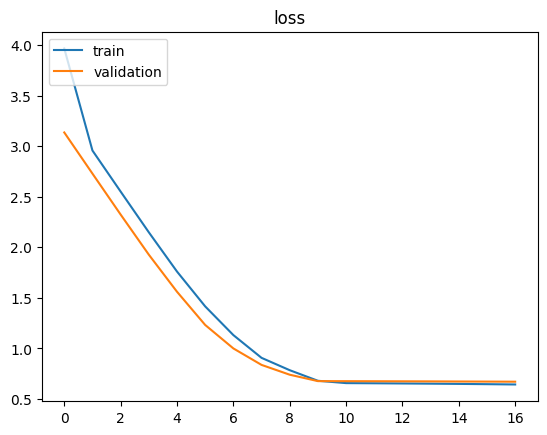

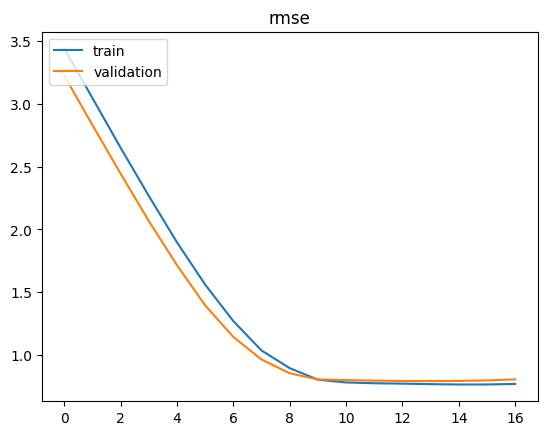

In [ ]:
from tensorflow.python.ops.array_ops import placeholder_with_default_eager_fallback
import matplotlib.pyplot as plt
loss_curve = history.history["loss"]
rmse_curve = history.history["rmse"]
#mae_curve  = history.history["mae"]


loss_val   = history.history["val_loss"]
rmse_val   = history.history["val_rmse"]
#mae_val    = history.history["val_mae"]


# ploter loss function
def ploter (title , curve , validation):
  plt.plot(curve , label = "train")
  plt.plot(validation , label = "validation")
  # plt.ylim(0,1)
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

ploter ('loss' , loss_curve , loss_val)
ploter ('rmse' , rmse_curve , rmse_val)
#ploter ('mae' , mae_curve , mae_val)


# **evaluation de model**

In [ ]:
test_userDATA = X_test[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
        'profile','cute','list','note','plain',
        'cool','funny','writer','photos']]

test_itemDATA = X_test[['Shopping', 'Books', 'Mags', 'Music & Video',
                          'Bookstores', 'Baby Gear & Furniture', 'Home Decor',
                          'Furniture Stores', 'Home & Garden', 'Auction Houses',
                          'Active Life', 'Fashion', 'Toy Stores', 'Hobby Shops',
                          'Comic Books', 'Department Stores', 'Grocery', 'Food',
                          'Electronics', 'Jewelry', 'Outdoor Gear', 'Golf Lessons',
                          'Sporting Goods', 'Golf Equipment', 'Golf', 'Fitness & Instruction',
                          'Sports Wear', 'Flooring', 'Home Services', 'Kitchen & Bath',
                          'Building Supplies', 'Interior Design', 'Hardware Stores', 'Appliances']]

In [ ]:
test_userID = X_test['user_id']
test_itemID = X_test['item_id']

In [ ]:
scores= SCARS.evaluate([[test_userID,test_userDATA,test_itemID,test_itemDATA],X_test['text'] , X_test['valuer_conf']],y_test,verbose=0)

In [ ]:
scores[1]

0.7800922989845276

# **#####**

In [ ]:
#Create model with hybridation (user and item id AND user and item DATA)
def build_SCARS_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers):
    print('SCARS MODEL ')
    #NHF part
    NHF = build_NHF_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers)
    print(NHF.output )
    print(NHF.input )

    #model of sentiment analysis part

    # definir les inputs de notre model
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="review")
    # le model pre-entrainer de bert
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # output contient the embedding of rveiew  1 : pooled_output est un tensor de dimension(batch ,768 ) contient la representation de review complet
    #                                          2  : sequence_output est un tensor de dimension(batch , 128 ,768) tel que 128 represtent les mot dans un review and 768 c'est la representaion d'un mot

    model_SA = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64 ,
                            input_shape=(1,128,768),
                            return_sequences = True ,
                            kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                            name='lstm1'))(outputs['sequence_output'])
    model_SA = tf.keras.layers.SimpleRNN(32 ,
                            return_sequences = True ,
                            kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                            name='lstm1')(model_SA)
    model_SA = tf.keras.layers.Dropout(0.5)(model_SA)
    model_SA = tf.keras.layers.Flatten()(model_SA)
    model_SA = tf.keras.layers.Dense(120, activation='relu', name='dense1')(model_SA)
    model_SA = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(model_SA)

    #  confidence part :
    confidence_input = tf.keras.layers.Input(shape = [1], name = 'conf_val')
    # confidence_model = tf.keras.layers.Dense(1, activation ='sigmoid')(confidence_input)

    # multiplier output de model_SA par la valeur de confiance correspondant
    model_final_de_sentiment = tf.keras.layers.Multiply()([confidence_input , model_SA])


    model_final_de_sentiment = tf.keras.Model(inputs=[text_input,confidence_input], outputs=[ model_final_de_sentiment])
    print(model_final_de_sentiment.output)
    print(model_final_de_sentiment.input)

    #  concatener NHF avec le model de sentiment
    concat_SCARS = concatenate([NHF.output , model_final_de_sentiment.output])


    out = Dense(1, activation='linear', name='SCARS')(concat_SCARS)

    SCARS_model = Model(inputs=[NHF.inputs, model_final_de_sentiment.inputs],outputs=out)

    return SCARS_model